In [1]:
import torch
from torch.utils.data import Dataset,DataLoader
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
from IPython.display import display


In [2]:
train_input_seq_50d = torch.load('train_input_seq_50d.pt')
train_target_seq_50d = torch.load('train_target_seq_50d.pt')
val_input_seq_50d = torch.load('val_input_seq_50d.pt')
val_target_seq_50d = torch.load('val_target_seq_50d.pt')

train_input_seq_300d = torch.load('train_input_seq_300d.pt')
train_target_seq_300d = torch.load('train_target_seq_300d.pt')
val_input_seq_300d = torch.load('val_input_seq_300d.pt')
val_target_seq_300d = torch.load('val_target_seq_300d.pt')

In [3]:
class Basic_Dataset(Dataset):

    def __init__(self, X,Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    # return a pair x,y at the index idx in the data set
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

train_set_50d = Basic_Dataset(train_input_seq_50d,train_target_seq_50d)
val_set_50d = Basic_Dataset(val_input_seq_50d,val_target_seq_50d)
train_set_300d = Basic_Dataset(train_input_seq_300d,train_target_seq_300d)
val_set_300d = Basic_Dataset(val_input_seq_300d,val_target_seq_300d)

print(train_set_50d.__len__())
print(val_set_50d.__len__())
print(train_set_300d.__len__())
print(val_set_300d.__len__())

9000
1000
9000
1000


In [4]:
batch_size = 1024

train_data_loader_50d = DataLoader(train_set_50d, batch_size=batch_size, shuffle=True)
val_data_loader_50d = DataLoader(val_set_50d, batch_size=batch_size, shuffle=True)

In [5]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [6]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_length, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_length = output_length
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True, bidirectional=False)

        # Define additional linear layers
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(hidden_dim, embedding_dim)  # Final layer maps back to embedding dimension

    def forward(self, input_embedding):
        # LSTM and initial linear layer
        input_embedding = input_embedding.double()
        if input_embedding.dim() == 2:
            input_embedding = input_embedding.unsqueeze(0)
        h0 = torch.randn(self.num_layers, input_embedding.size(0), self.hidden_dim).double().to(input_embedding.device)
        c0 = torch.randn(self.num_layers, input_embedding.size(0), self.hidden_dim).double().to(input_embedding.device)
        lstm_out, _ = self.lstm(input_embedding, (h0, c0))
        output = self.linear1(lstm_out[:, 0, :])

        # Additional layers
        output = self.relu(output)
        output = self.dropout(output)
        output = self.linear2(output)

        # Generating the sequence of embeddings
        outputs = [output]
        for _ in range(1, self.output_length):
            lstm_out, _ = self.lstm(output.unsqueeze(1))
            output = self.linear1(lstm_out[:, 0, :])
            output = self.relu(output)
            output = self.dropout(output)
            output = self.linear2(output)
            outputs.append(output)

        return torch.stack(outputs, dim=1)



In [7]:
# Instantiate the model with hyperparameters
num_layers = 1
dropout = 0.3
wiki_model_1 = LSTMModel(train_input_seq_50d.shape[2], 512, train_target_seq_50d.shape[1], num_layers, dropout)

print(wiki_model_1)

wiki_model_1 = wiki_model_1.double().to(device)

# Define Loss, Optimizer
loss_fn = nn.MSELoss()

optimizer = torch.optim.SGD(wiki_model_1.parameters(), lr=0.01,weight_decay=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5) 

LSTMModel(
  (lstm): LSTM(50, 512, batch_first=True, dropout=0.3)
  (linear1): Linear(in_features=512, out_features=512, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=512, out_features=50, bias=True)
)


c:\ProgramData\anaconda3\envs\conda310\lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\TaiSh\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 100/100 [06:19<00:00,  3.79s/it]

Final Validation Loss: 4.1664511472776775


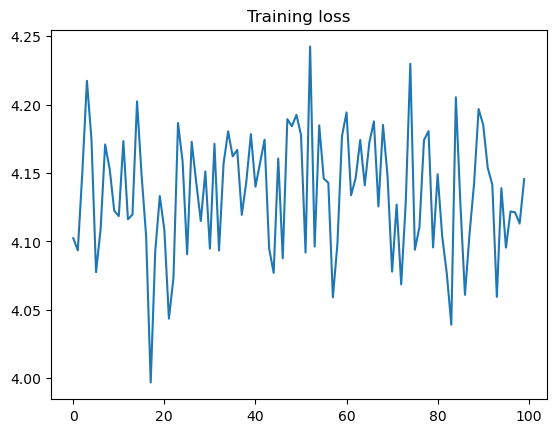

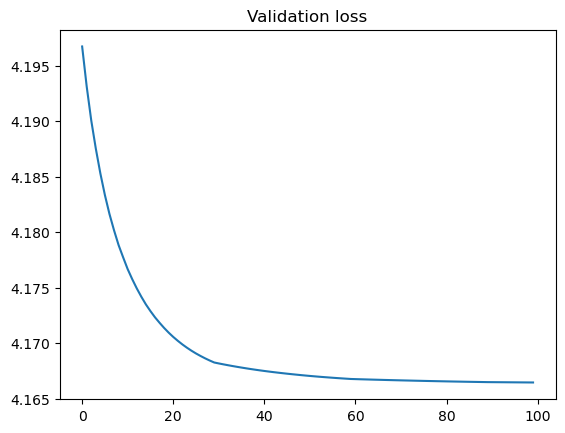

In [8]:
num_epochs = 100

train_losses = []
val_losses = []

# Early stopping parameters
best_val_loss = float('inf')
patience = 5  # How many epochs to wait after last time validation loss improved.
trigger_times = 0  # This will count the number of times the validation loss did not improve.


try:
    wiki_model_1 = torch.load('wiki_model_1.pt')
    
    img = mpimg.imread('wiki_train_loss_1.png')
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    img = mpimg.imread('wiki_val_loss_1.png')
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()
except:
    for epoch in tqdm(range(num_epochs)):
        for input_seq_batch, target_seq_batch in train_data_loader_50d:
            input_seq_batch = input_seq_batch.to(device)
            target_seq_batch = target_seq_batch.to(device)
            optimizer.zero_grad()
            target_seq_hat = wiki_model_1(input_seq_batch)
            loss = loss_fn(target_seq_hat, target_seq_batch)
            loss.backward()
            optimizer.step()
        scheduler.step()

        train_losses.append(loss.item())

        # Validation loop
        wiki_model_1.eval()  
        with torch.no_grad():
            for input_seq_batch, target_seq_batch in val_data_loader_50d:
                input_seq_batch = input_seq_batch.to(device)
                target_seq_batch = target_seq_batch.to(device)
                target_seq_hat = wiki_model_1(input_seq_batch)
                val_loss = loss_fn(target_seq_hat, target_seq_batch)

        val_losses.append(val_loss.item())
        

        # Check for improvement
        if val_losses[epoch] < best_val_loss:
            best_val_loss = val_losses[epoch]
            trigger_times = 0
        else:
            trigger_times += 1

            # Check if the improvement patience has run out
            if trigger_times >= patience:
                print(f'Early stopping at epoch {epoch}')
                break

        # Reset val_losses for the next epoch
        wiki_model_1.train() 
    print(f'Final Validation Loss: {val_losses[epoch]}')    
    torch.save(wiki_model_1, 'wiki_model_1.pt')

    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(train_losses)
    plt.title('Training loss')
    plt.show()
    fig.savefig('wiki_train_loss_1.png')
    
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(val_losses)
    plt.title('Validation loss')
    plt.show()
    fig.savefig('wiki_val_loss_1.png')

In [9]:
from gensim.models import Word2Vec

tuned_embedding_model = Word2Vec.load("wikipedia_glove_50d.model")
embedding_wv = tuned_embedding_model.wv

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

def find_closest_word(embedding, model):
    max_similarity = -1
    most_similar_word = None

    # Detach the tensor, move it to CPU, and convert to NumPy
    embedding = embedding.detach().cpu().numpy()

    for word in model.key_to_index:
        # Calculate similarity and find the most similar word
        sim = cosine_similarity([embedding], [model[word]])
        if sim > max_similarity:
            max_similarity = sim
            most_similar_word = word

    return most_similar_word

def translate_sentence(sentence, model):
    translation = ''
    for word in sentence:
        translation += find_closest_word(word, model) + ' '
    return translation


def predict(model, title):
    title = np.array(embedding_wv[title])
    title = torch.from_numpy(title).to(device)
    out = model(title)
    out = list(out[0])
    return translate_sentence(out, embedding_wv)


test_sentence = ['songs']
print(f'Test title: {test_sentence}')
print(f'Predicted article: {predict(wiki_model_1, test_sentence)}')

Test title: ['songs']
Predicted article: came came came came came came came came came came 


In [11]:
batch_size = 1024

train_data_loader_300d = DataLoader(train_set_300d, batch_size=batch_size, shuffle=True)
val_data_loader_300d = DataLoader(val_set_300d, batch_size=batch_size, shuffle=True)

In [14]:
# Instantiate the model with hyperparameters
num_layers = 2
dropout = 0.2
wiki_model_2 = LSTMModel(train_input_seq_300d.shape[2], 1024, train_target_seq_300d.shape[1], num_layers, dropout)

print(wiki_model_2)

wiki_model_2 = wiki_model_2.double().to(device)

# Define Loss, Optimizer
loss_fn = nn.MSELoss()

optimizer = torch.optim.SGD(wiki_model_2.parameters(), lr=0.005,weight_decay=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5) 

LSTMModel(
  (lstm): LSTM(50, 1024, num_layers=2, batch_first=True, dropout=0.2)
  (linear1): Linear(in_features=1024, out_features=1024, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=1024, out_features=50, bias=True)
)


100%|██████████| 100/100 [55:52<00:00, 33.52s/it]


Final Validation Loss: 4.167281438017858


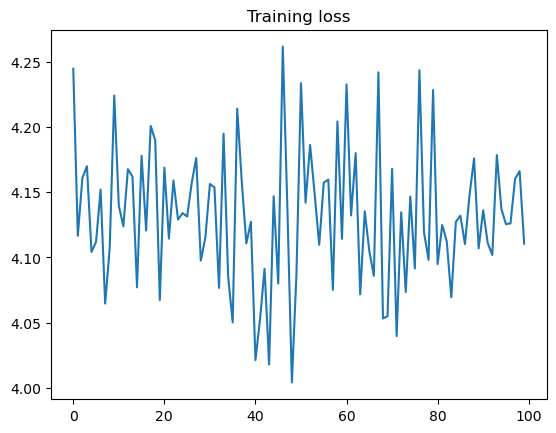

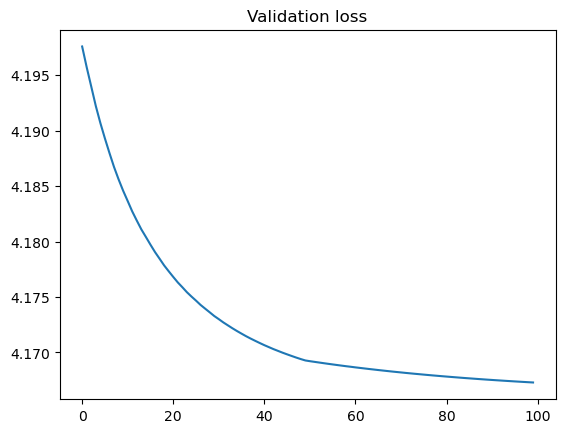

In [15]:
num_epochs = 100

train_losses = []
val_losses = []

# Early stopping parameters
best_val_loss = float('inf')
patience = 5  # How many epochs to wait after last time validation loss improved.
trigger_times = 0  # This will count the number of times the validation loss did not improve.


try:
    wiki_model_2 = torch.load('wiki_model_2.pt')
    
    img = mpimg.imread('wiki_train_loss_2.png')
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    img = mpimg.imread('wiki_val_loss_2.png')
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()
except:
    for epoch in tqdm(range(num_epochs)):
        wiki_model_2.train()
        for input_seq_batch, target_seq_batch in train_data_loader_300d:
            input_seq_batch = input_seq_batch.to(device)
            target_seq_batch = target_seq_batch.to(device)
            optimizer.zero_grad()
            target_seq_hat = wiki_model_2(input_seq_batch)
            loss = loss_fn(target_seq_hat, target_seq_batch)
            loss.backward()
            optimizer.step()
        scheduler.step()

        train_losses.append(loss.item())

        # Validation loop
        wiki_model_2.eval()  
        with torch.no_grad():
            for input_seq_batch, target_seq_batch in val_data_loader_300d:
                input_seq_batch = input_seq_batch.to(device)
                target_seq_batch = target_seq_batch.to(device)
                target_seq_hat = wiki_model_2(input_seq_batch)
                val_loss = loss_fn(target_seq_hat, target_seq_batch)

        val_losses.append(val_loss.item())
        

        # Check for improvement
        if val_losses[epoch] < best_val_loss:
            best_val_loss = val_losses[epoch]
            trigger_times = 0
        else:
            trigger_times += 1

            # Check if the improvement patience has run out
            if trigger_times >= patience:
                print(f'Early stopping at epoch {epoch}')
                break

        # Reset val_losses for the next epoch
        wiki_model_2.train() 
    print(f'Final Validation Loss: {val_losses[epoch]}')
    torch.save(wiki_model_2, 'wiki_model_2.pt')

    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(train_losses)
    plt.title('Training loss')
    plt.show()
    fig.savefig('wiki_train_loss_2.png')
    
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(val_losses)
    plt.title('Validation loss')
    plt.show()
    fig.savefig('wiki_val_loss_2.png')

In [16]:
test_sentence = ['songs']
print(f'Test title: {test_sentence}')
print(f'Predicted article: {predict(wiki_model_2, test_sentence)}')

Test title: ['songs']
Predicted article: came came came came came came came came came came 


In [22]:
batch_size = 256

train_data_loader_300d = DataLoader(train_set_300d, batch_size=batch_size, shuffle=True)
val_data_loader_300d = DataLoader(val_set_300d, batch_size=batch_size, shuffle=True)

In [23]:
# Instantiate the model with hyperparameters
num_layers = 2
dropout = 0.2
wiki_model_3 = LSTMModel(train_input_seq_300d.shape[2], 2048, train_target_seq_300d.shape[1], num_layers, dropout)

print(wiki_model_3)

wiki_model_3 = wiki_model_3.double().to(device)

# Define Loss, Optimizer
loss_fn = nn.MSELoss()

optimizer = torch.optim.SGD(wiki_model_3.parameters(), lr=0.0001,weight_decay=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5) 

LSTMModel(
  (lstm): LSTM(50, 2048, num_layers=2, batch_first=True, dropout=0.2)
  (linear1): Linear(in_features=2048, out_features=2048, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=2048, out_features=50, bias=True)
)


In [24]:
num_epochs = 15

train_losses = []
val_losses = []

# Early stopping parameters
best_val_loss = float('inf')
patience = 3  # How many epochs to wait after last time validation loss improved.
trigger_times = 0  # This will count the number of times the validation loss did not improve.


try:
    wiki_model_3 = torch.load('wiki_model_3.pt')
    
    img = mpimg.imread('wiki_train_loss_3.png')
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    img = mpimg.imread('wiki_val_loss_3.png')
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()
except:
    for epoch in tqdm(range(num_epochs)):
        wiki_model_2.train()
        for input_seq_batch, target_seq_batch in train_data_loader_300d:
            input_seq_batch = input_seq_batch.to(device)
            target_seq_batch = target_seq_batch.to(device)
            optimizer.zero_grad()
            target_seq_hat = wiki_model_3(input_seq_batch)
            loss = loss_fn(target_seq_hat, target_seq_batch)
            loss.backward()
            optimizer.step()
        scheduler.step()

        train_losses.append(loss.item())

        # Validation loop
        wiki_model_3.eval()  
        with torch.no_grad():
            for input_seq_batch, target_seq_batch in val_data_loader_300d:
                input_seq_batch = input_seq_batch.to(device)
                target_seq_batch = target_seq_batch.to(device)
                target_seq_hat = wiki_model_3(input_seq_batch)
                val_loss = loss_fn(target_seq_hat, target_seq_batch)

        val_losses.append(val_loss.item())
        

        # Check for improvement
        if val_losses[epoch] < best_val_loss:
            best_val_loss = val_losses[epoch]
            trigger_times = 0
        else:
            trigger_times += 1

            # Check if the improvement patience has run out
            if trigger_times >= patience:
                print(f'Early stopping at epoch {epoch}')
                break

        # Reset val_losses for the next epoch
        wiki_model_3.train() 
    print(f'Final Validation Loss: {val_losses[epoch]}')
    torch.save(wiki_model_3, 'wiki_model_3.pt')

    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(train_losses)
    plt.title('Training loss')
    plt.show()
    fig.savefig('wiki_train_loss_3.png')
    
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(val_losses)
    plt.title('Validation loss')
    plt.show()
    fig.savefig('wiki_val_loss_3.png')

 27%|██▋       | 4/15 [08:33<23:58, 130.74s/it]